In [1]:
# data analysis
import pandas as pd
import numpy as np

# data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split

# data visualization
from bokeh.io import show, output_notebook
from bokeh.layouts import gridplot, column, row
from bokeh.plotting import figure
from bokeh.palettes import Spectral11 as cm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
output_notebook()

# time series analysis
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# machine learning algorithm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingClassifier

# check runningtime
from time import time

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

/Users/ytian45/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Loading BokehJS ...

/Users/ytian45/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1.Input Data

* The project provides with historical sales data for 1,115 Rossmann stores. 
* The task is to forecast the "Sales" column for the test set. 
* Note that some stores in the dataset were temporarily closed for refurbishment.

In [2]:
# read the file
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_store = pd.read_csv('store.csv') 

In [3]:
# keep test_id
test_id = df_test.loc[:, 'Id']

In [4]:
# print the train/test dataset
print(df_train.head(1))
print('-'*80)
print(df_test.head(1))
print('-'*80)

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   

   SchoolHoliday  
0              1  
--------------------------------------------------------------------------------
   Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
--------------------------------------------------------------------------------


* Sales: 
    * the turnover for any given day (target variable).
* Customers: 
    * the number of customers on a given day.
* Open: 
    * an indicator for whether the store was open: 0 = closed, 1 = open.
* Promo: 
    * indicates whether a store is running a promo on that day.
* StateHoliday: 
    * indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday: 
    * indicates if the (Store, Date) was affected by the closure of public schools.

##  1.1 Show Summary

In [5]:
'''
trainset doesn't have missing value.
testset has missing value in open feature.
besides store, store type, assortment and promo2, the other feature in storeset has missing value. 
'''
print(df_train.info())
print('-'*40)
print()
print(df_test.info())
print('-'*40)
print()
print(df_store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None
----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: floa

## 1.2 Shape of Dataset 

In [6]:
print('The shape of trainset is', df_train.shape)
print('The shape of testset is', df_test.shape)
print('The shape of storeset is', df_store.shape)

The shape of trainset is (1017209, 9)
The shape of testset is (41088, 8)
The shape of storeset is (1115, 10)


## 1.3 Column Name of Dataset 

In [7]:
print('The column name of trainset are') 
print(list(df_train.columns))
print()
print('The column name of testset are')
print(list(df_test.columns))
print()
print('The column name of storeset are')
print(list(df_store.columns))

The column name of trainset are
['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']

The column name of testset are
['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']

The column name of storeset are
['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


## 1.4 Adjust Trainset Size

In [8]:
print(df_train.groupby(df_train['Open'][df_train['Sales']==0]).size())

Open
0.0    172817
1.0        54
dtype: int64


When the stores have no sales in one day, most of them are closed and only 54 of them are open at that day.

The project is aim to predict the sale in differents stores. Thus, zero sale has no meanning and doesn't help us to predict the testset.

Drop the row with zero sale.

In [9]:
# drop the zeros sales
df_train = df_train[df_train['Sales']!=0]

In [10]:
print(df_train.shape)

(844338, 9)


# 2. Data Preprocessing
## 2.1 Based on Train and Test dataset
### 2.1.1 Convert Date Feature

In [11]:
'''
Since the Date feature is string in train and test dataset, 
we can use pandas api to convert string value to pandas date value
'''
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [12]:
def more_time_feature(df):
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.weekofyear
    return df

In [13]:
# add more time feature
df_train = more_time_feature(df_train)
df_test = more_time_feature(df_test)

In [14]:
print(df_train.shape)
print(df_test.shape)

(844338, 13)
(41088, 12)


### 2.1.2 Label Encode in StateHoliday Feature

In [15]:
# check the stateholiday column in both train and test set
print(df_train.groupby('StateHoliday').size())
print()
print(df_test.groupby('StateHoliday').size())

StateHoliday
0    112120
0    731308
a       694
b       145
c        71
dtype: int64

StateHoliday
0    40908
a      180
dtype: int64


In [16]:
'''
From the trainset and test, I find the data type is not unique for value 0.
Thus, I replace the categorical 0 and numerial 0 to a new categorical variable call no_holiday
'''
df_train['StateHoliday'] = df_train['StateHoliday'].replace([0, '0'], 'No_Holiday')
df_test['StateHoliday'] = df_test['StateHoliday'].replace([0, '0'], 'No_Holiday')

In [17]:
print(df_train.groupby('StateHoliday').size())
print()
print(df_test.groupby('StateHoliday').size())

StateHoliday
No_Holiday    843428
a                694
b                145
c                 71
dtype: int64

StateHoliday
No_Holiday    40908
a               180
dtype: int64


In [18]:
# label encode
df_train['StateHoliday'] = df_train['StateHoliday'].replace(['No_Holiday', 'a', 'b', 'c'], [1,2,3,4])
df_test['StateHoliday'] = df_test['StateHoliday'].replace(['No_Holiday', 'a', 'b', 'c'], [1,2,3,4])

In [19]:
print(df_train.groupby('StateHoliday').size())
print()
print(df_test.groupby('StateHoliday').size())

StateHoliday
1    843428
2       694
3       145
4        71
dtype: int64

StateHoliday
1    40908
2      180
dtype: int64


In [20]:
print(df_train.shape)
print(df_test.shape)

(844338, 13)
(41088, 12)


### 2.1.3 Imputate missing value in Open Feature

In [21]:
# check the missing value
print(df_train.isnull().sum())
print('-'*20)
print(df_test.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
Year             0
Month            0
Day              0
WeekOfYear       0
dtype: int64
--------------------
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
Year              0
Month             0
Day               0
WeekOfYear        0
dtype: int64


In [22]:
# use the mode in trainset Open feature to imputate the missing value in testset
mode_noh = df_train['Open'].mode()[0]
df_test['Open'] = df_test['Open'].fillna(mode_noh)

In [23]:
print(df_test.isnull().sum())

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
Year             0
Month            0
Day              0
WeekOfYear       0
dtype: int64


## 2.2 Base Store Dataset

In [24]:
# show the store dataframe
df_store.head(1)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


Store Dataset is another dataset include all store information in train and testset
* Store: 
    * a unique Id for each store
* StoreType: 
    * differentiates between 4 different store models: a, b, c, d
* Assortment: 
    * describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance: 
    * distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year]: 
    * gives the approximate year and month of the time the nearest competitor was opened
* Promo2: 
    * Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week]:
    * describes the year and calendar week when the store started participating in Promo2
* PromoInterval: 
    * describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### 2.2.1 Imputate missing value 

In [25]:
# check the missing value
print(df_store.isnull().sum()/df_store.shape[0]*100)

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.269058
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek              48.789238
Promo2SinceYear              48.789238
PromoInterval                48.789238
dtype: float64


#### Missing values in CompetitionDistance 

In [26]:
'''
After checking the missing value in CompetitionDistance feature
I can find storetype, assortment, and promo2 have full information in them
'''
print(df_store[df_store.CompetitionDistance.isnull()])

     Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov  


In [27]:
# find mean value of competitiondistance based on the specific storetype, assortment and promo2.
comp_impu = df_store['CompetitionDistance'][(df_store['StoreType']=='d')&
                                            (df_store['Assortment']=='a')&
                                            (df_store['Promo2']==0)].mean()

In [28]:
df_store['CompetitionDistance'] = df_store['CompetitionDistance'].fillna(comp_impu)
# df_store['CompetitionDistance'] = df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].mean())

In [29]:
print(df_store[df_store.CompetitionDistance.isnull()])

Empty DataFrame
Columns: [Store, StoreType, Assortment, CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2, Promo2SinceWeek, Promo2SinceYear, PromoInterval]
Index: []


#### Replace NA by 0 in other feature

In [30]:
print(df_store.dtypes)

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object


In [31]:
'''
After identifying the information in store dataset, I use 0 to imputate all missing value in other feature
'''
df_store = df_store.fillna(0)

In [32]:
print(df_store.isnull().sum()/df_store.shape[0]*100)

Store                        0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64


### 2.2.2 Label Encode StoreType, Assortment Feature

In [33]:
# in order to label encode, I need to change promointerval feature to be same datatype
df_store['PromoInterval'] = df_store['PromoInterval'].replace(0, 'None')

In [34]:
# check the value categories in three feature
col_name = ['StoreType', 'Assortment', 'PromoInterval']
for col in col_name:
    print(df_store.groupby(col).size())

StoreType
a    602
b     17
c    148
d    348
dtype: int64
Assortment
a    593
b      9
c    513
dtype: int64
PromoInterval
Feb,May,Aug,Nov     130
Jan,Apr,Jul,Oct     335
Mar,Jun,Sept,Dec    106
None                544
dtype: int64


In [35]:
# label encode by sklearn
le = LabelEncoder()
for col in col_name:
    le.fit(df_store[col])
    df_store[col] = le.transform(df_store[col])

## 2.3 Merge store dataset and train/test

In [36]:
# merge the store dataset and train/test by store id
train = pd.merge(df_train, df_store, on='Store')
test = pd.merge(df_test, df_store, on='Store')

In [37]:
# reset index by Date
train = train.set_index('Date')
test = test.set_index('Date')

# 3 Data Visualization

## 3.1 Heatmap 

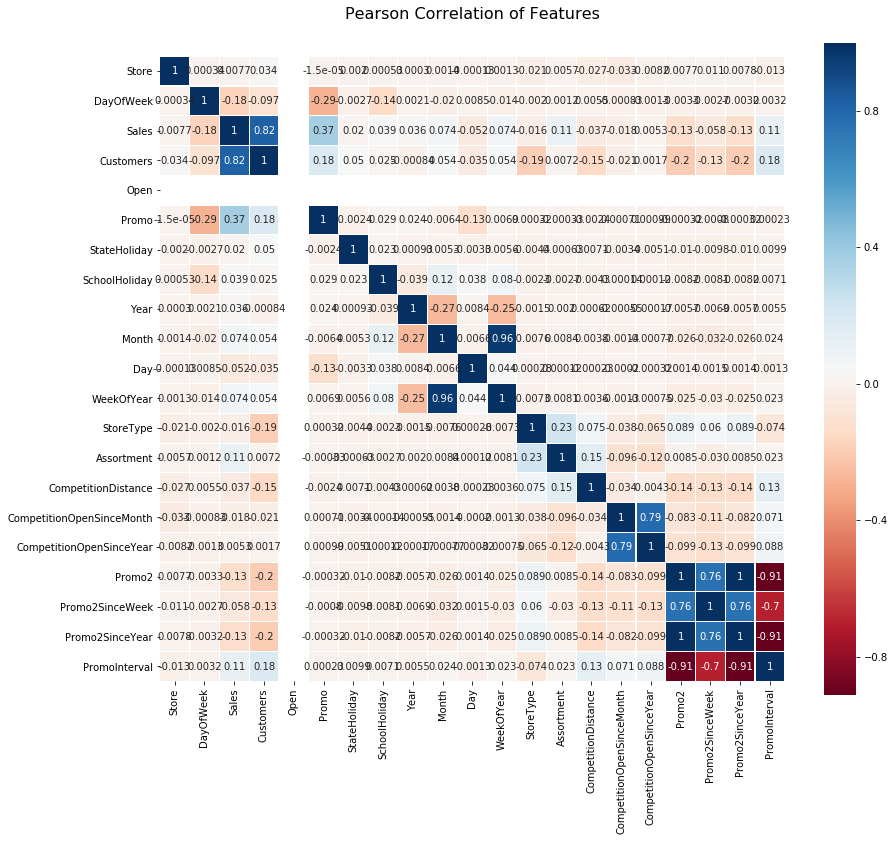

In [38]:
# check feature correlation using a heatmap
plt.subplots(figsize = (14, 12))
colormap = plt.cm.RdBu
plt.title('Pearson Correlation of Features', y=1.05, size=16)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## 3.2 Visualization based on Sales in StoresType 

In [39]:
# print an sample store id for different StoreType
st_sample = []
for type in list(train.groupby('StoreType').size().index):
    # Choose the first store information from four storetype
    st_sample.append(train['Store'][train['StoreType']==type].head(1)[0])

# keep original store_type 
store_type = ['a', 'b', 'c', 'd'] 

In [40]:
# create the outline for bokeh graph
def outline():
    p = figure(plot_width=800, plot_height=350,
               title="Sales in Storetypes",
               x_axis_type='datetime',
               x_axis_label='Date', y_axis_label='Sales Amount')
    p.xgrid.minor_grid_line_color = 'black'
    p.xgrid.minor_grid_line_alpha = 0.1
    
    return p

In [41]:
'''
Create the figure of sales based on stores type
After using bokeh library, you can check the distinguish storetype by clicking the their legend
''' 
p = outline()

for i in range(len(st_sample)):
    date = train.index[train['Store']==st_sample[i]]
    sale = train['Sales'][train['Store']==st_sample[i]]
    
    p.line(x = date, y = sale,
           line_width=2, color=cm[i], alpha=0.8, legend=('Store_type ')+store_type[i])

p.legend.click_policy="hide"
show(p)

## 3.3 Time Series Components

A given time series is thought to consist of three systematic components including trend, seasonality, cyclical and one non-systematic component called noise.

* Trend: Long run increase or decrease over time.
* Seasonal: Short term regular wave like patterns
* Cyclical: Long term wave like patterns
* Irregular(Noise): The random variation in the series

A series is thought to be an aggregate or combination of these four components.

#### Additive Model
y(t) = Trend + Seasonality/Cyclical + Noise

#### Multiplicative Model
y(t) = Trend /dot Seasonality/Cyclical /dot Noise

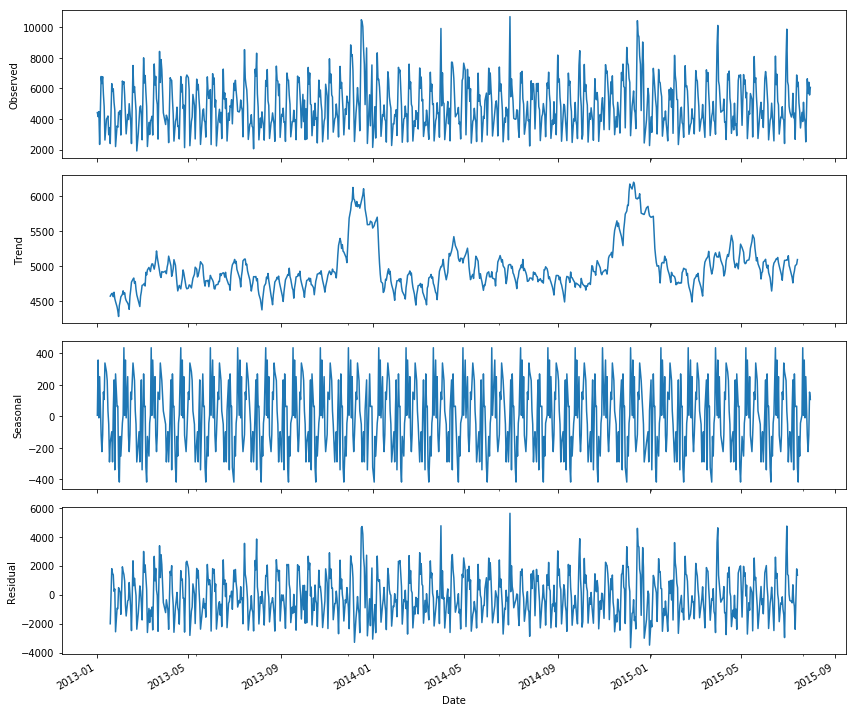

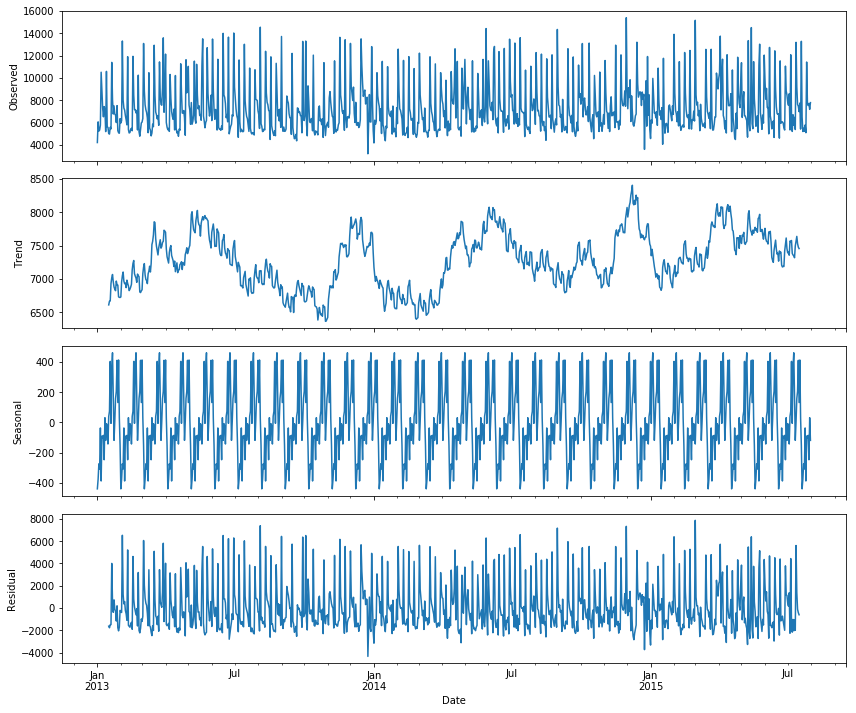

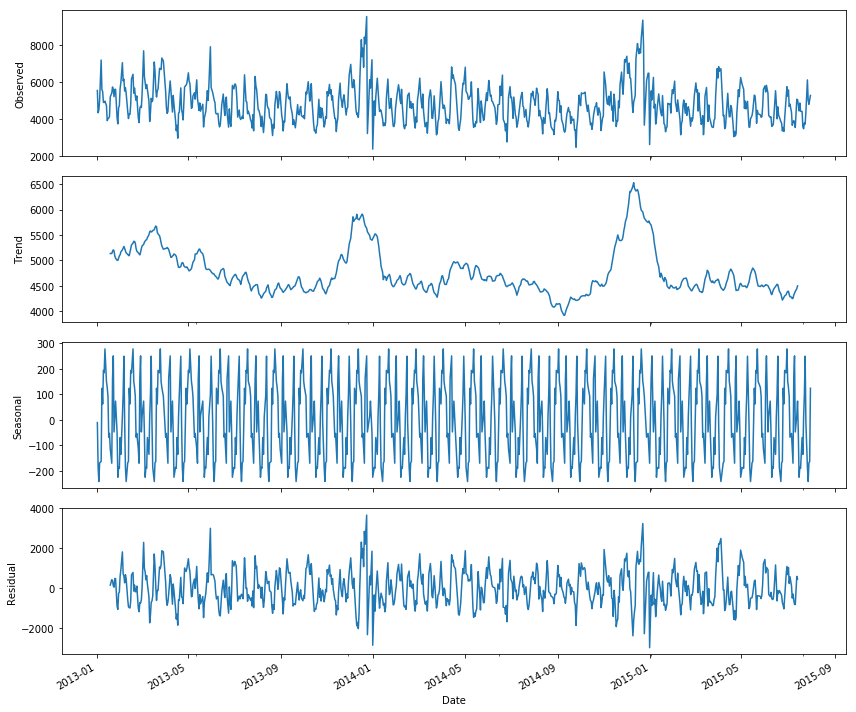

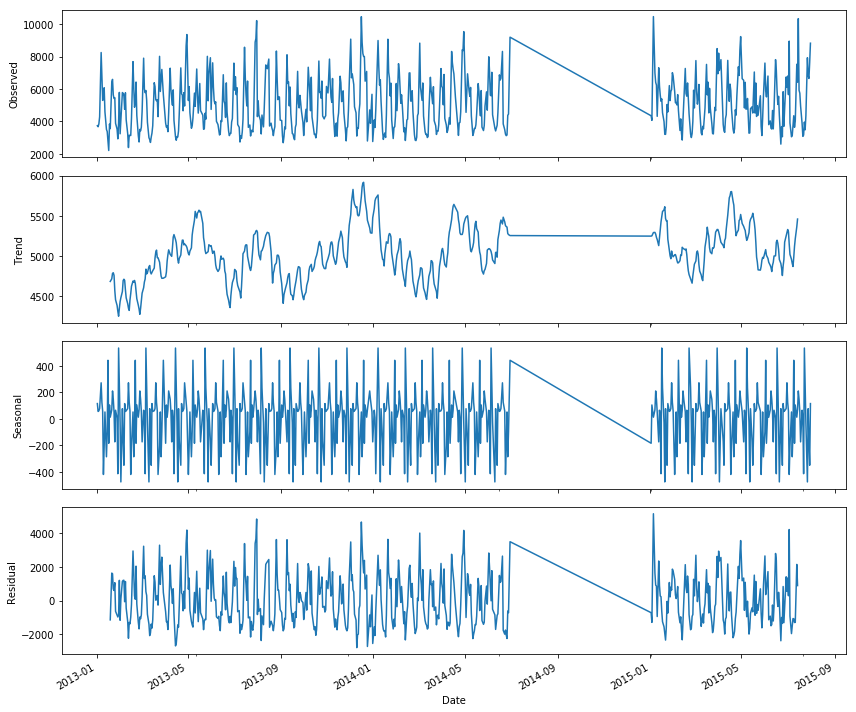

In [42]:
'''
Create the figure of Additive Model in sales based on stores type
''' 
rcParams['figure.figsize'] = [12, 10]
for i in range(len(st_sample)):
    date = train.index[train['Store']==st_sample[i]]
    sale = train['Sales'][train['Store']==st_sample[i]]
    # freq is set to 31 day/ one month
    res = sm.tsa.seasonal_decompose(sale, model = 'additive', freq = 31)
    resplot = res.plot()

## 3.4 Stationarity of a Time Series 

A Time series(TS) is said to be stationary if its statistical properties such as mean, variance remain constant over time.

For practical purposes, assume the series to be stationary if it has constant statistical properties over time, the statistical properties is:

* constant mean
* constant variance
* an autocovariance that does not depend on time. 

### 3.4.1 Moving Average Smoothing

Moving average smoothing is a naive and effective technique in time series forecasting. It can be used for data preparation, feature engineering, and even directly for making predictions.

The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes. Moving averages are a simple and common type of smoothing used in time series analysis and time series forecasting.

A moving average requires that you specify a window size called the window width. This defines the number of raw observations used to calculate the moving average value.

There are two main types of moving average that are used: Centered and Trailing Moving Average.

* Centered Moving Average:

  The value at time (t) is calculated as the average of raw observations at, before, and after time (t)
    * a center moving average with a window of 3 would be calculated as
    * center_ma(t) = mean(obs(t-1), obs(t), obs(t+1))
* Trailing Moving Average:

    The value at time (t) is calculated as the average of the raw observations at and before the time (t).
    * a trailing moving average with a window of 3 would be calculated as:
    * trail_ma(t) = mean(obs(t-2), obs(t-1), obs(t))

In [43]:
'''
Create the figure of moving average smoothing in sales based on stores type
After using bokeh library, you can check the different storetype sale by clicking the legend
''' 
for i in range(len(st_sample)):
    p = outline() 
    
    date = train.index[train['Store']==st_sample[i]]
    sale = train['Sales'][train['Store']==st_sample[i]]
    move_mean = pd.rolling_mean(train['Sales'][train['Store']==st_sample[i]], window=31)
    move_std = pd.rolling_std(train['Sales'][train['Store']==st_sample[i]], window=31)
    
    p.line(x=date, y=sale,
           line_width=2, color=cm[i*2], alpha=1, legend=('Store_type ')+store_type[i])
    p.line(x=date, y=move_mean,
           line_width=2, color=cm[(i+1)*2], alpha=1, legend=(('Moving_Mean ')+store_type[i]))
    p.line(x=date, y=move_std,
           line_width=2, color=cm[(i+2)*2], alpha=0.9, legend=(('Moving_Std ')+store_type[i]))
    p.legend.click_policy="hide"
    show(p)

### 3.4.2 Autocovariance

Autocorrelation is a measure of the internal correlation within a time series. It is a way of measuring and explaining internal association between observations in a time series.

Autocorrelation quantifies the internal association: assigning a value of +1 to strong positive association, -1 to strong negative association and 0 to no association.

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4

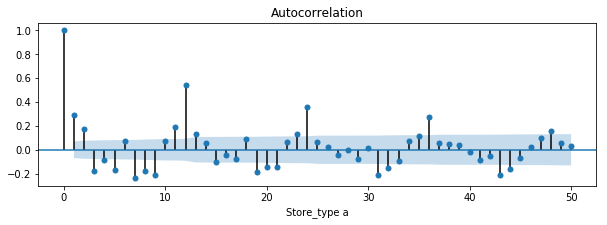

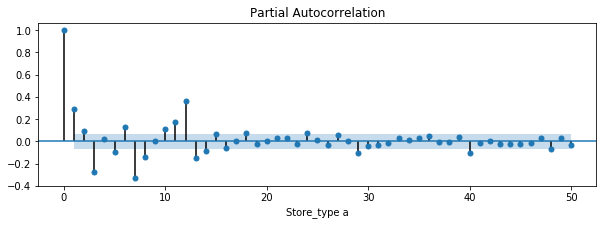

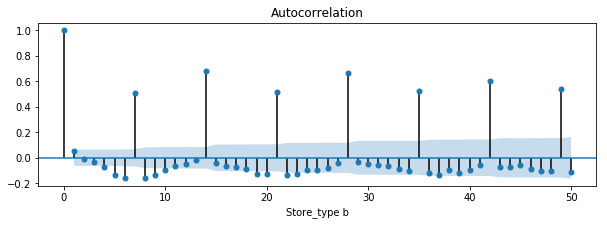

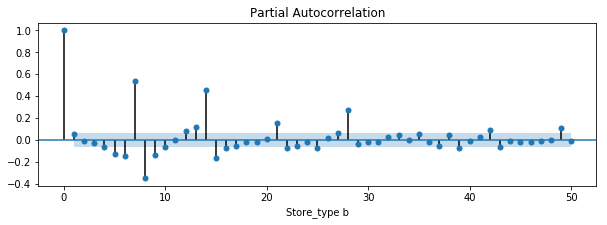

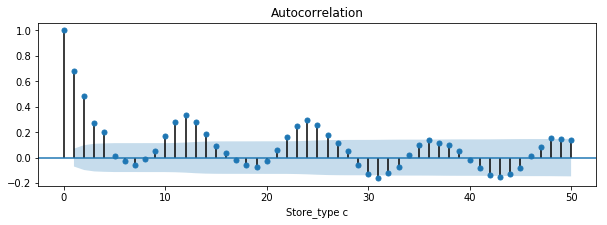

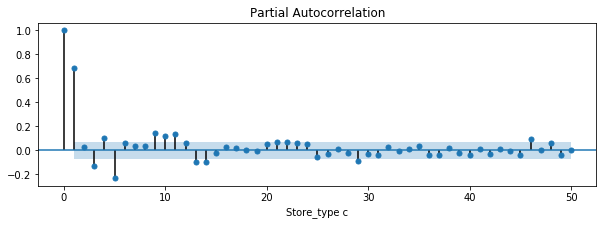

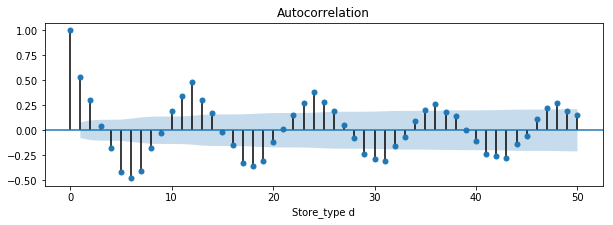

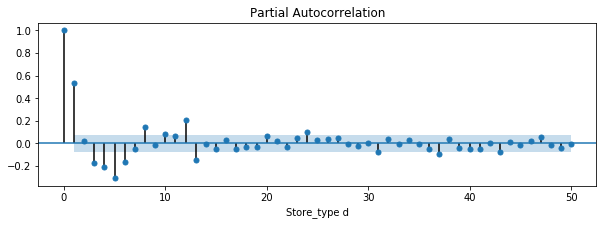

In [44]:
'''
Create the figure of Autocorrelation in sales based on stores type
''' 
rcParams['figure.figsize'] = [10, 3]
for i in range(len(st_sample)):
    date = train.index[train['Store']==st_sample[i]]
    sale = train['Sales'][train['Store']==st_sample[i]]
    
    #.title(('Store_type ')+store_type[i])
    plt.xlabel(('Store_type ')+store_type[i])
    #plt.ylabel('ylabel')
    plot_acf(sale, lags = 50, ax = plt.gca())
    plt.show()
    plt.xlabel(('Store_type ')+store_type[i])
    plot_pacf(sale, lags = 50, ax = plt.gca())
    plt.show()

# 4. Model Selection 

The Evaluation formula:

$\textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i - \hat{y}_i}{y_i}\right)^2}$

In [45]:
# evaluation formula
def rmspe(y_pred, y_true):
    return np.sqrt(np.mean(((y_true-y_pred)/y_true)**2))

In [46]:
# 3 Fold CV
kfold = 3

In [47]:
# split the train/test by store_id
def store_split(store_id, train_stores, test_stores):
    '''
    From the kaggle, Sales is our lable and Customers is the feature corresponding to Sales. 
    Since Customers feature is not in the testset, we drop the Sales and Customers from train set.
    Create a new variable label to store Sales.
    '''
    train = train_stores[store_id]
    label = train.loc[:, 'Sales']
    train_feature = train.drop(['Sales', 'Customers'], axis=1)
    

    # Create a new variable store_id to store Id
    test = test_stores[store_id]
    test_id = test.loc[:, 'Id'] 
    test_feature = test.drop(['Id'], axis=1)
        
    return train_feature, label, test_id, test_feature, 

In [48]:
# split the train/test set by store
train_stores = dict(list(train.groupby('Store')))
test_stores = dict(list(test.groupby('Store')))

## 4.1 Random Forest

In [49]:
s_time = time() 

In [50]:
# Build model based on each test store
rf_sub = pd.Series()
for s_rf in test_stores:
    rf_train, rf_label, rf_id, rf_test = store_split(s_rf, train_stores, test_stores)
    
    # call machine learning api
    rf = RandomForestRegressor()
    error = []
    # cross valiation to check the result
    for cv in range(kfold):
        X_train, X_valid, y_train, y_valid = train_test_split(rf_train, rf_label, test_size=0.2)
        rf.fit(X_train, y_train)
        pred = rf.predict(X_valid)
        error.append(rmspe(pred, np.array(y_valid)))
        
    #print(round(np.mean(error),2))
    
    # pred the test set      
    rf.fit(rf_train, rf_label)
    rf_pred = rf.predict(rf_test)

    rf_sub = rf_sub.append(pd.Series(rf_pred, index=rf_id))

In [51]:
e_time = time()
print('Running time of Random_Forest is', round((e_time-s_time)/60, 2), 'min')

Running time of Random_Forest is 1.36 min


In [52]:
print(round(np.mean(error),2))
print(rf_sub.shape)

0.14
(41088,)


## 4.2 Xgboost

In [53]:
s_time = time() 

In [56]:
# Build model based on each test store
xgb_sub = pd.Series()
for s_xgb in test_stores:
    xgb_train, xgb_label, xgb_id, xgb_test = store_split(s_xgb, train_stores, test_stores)
    
    # call machine learning api
    xgb_class = XGBRegressor()
        
    X_train, X_valid, y_train, y_valid = train_test_split(xgb_train, xgb_label, test_size=0.2)
    
    # Update the parameter
    # params range
    xgb_params = {'subsample': [0.7, 0.9],
                  'colsample_bytree': [0.7],
                  'max_depth': [5, 10]}
    # cross validation to find best params
    xgb_grid = GridSearchCV(xgb_class, xgb_params)
    xgb_grid.fit(X_train, y_train)
    
    # predict the validation accuracy 
    pred = xgb_grid.best_estimator_.predict(X_valid)
    
    # check the trainset result
    #print('The accurary for train store', train_stores[s_xgb].Store.unique(), round(rmspe(pred, np.array(y_valid)), 3))
     
    # predict the test set 
    xgb_pred = xgb_grid.best_estimator_.predict(xgb_test)      
    xgb_sub = xgb_sub.append(pd.Series(xgb_pred, index=xgb_id))

In [58]:
e_time = time()
print('Running time of Xgboost is', round((e_time-s_time)/60, 2), 'min')
print(xgb_sub.shape)

Running time of Xgboost is 15.66 min
(41088,)


## 4.3 LightGBM 

In [59]:
s_time = time() 

In [60]:
# Build model based on each test store
lgb_sub = pd.Series()
for s_lgb in test_stores:
    lgb_train, lgb_label, lgb_id, lgb_test = store_split(s_lgb, train_stores, test_stores)

    # call machine learning api
    lgb_class = LGBMRegressor()
        
    X_train, X_valid, y_train, y_valid = train_test_split(lgb_train, lgb_label, test_size=0.2)
    
    # Update the parameter
    # params
    lgb_params = {'max_depth': [5, 15], 
                 'learning_rate': [0.1, 1]}

    # cross validation to find best params
    lgb_grid = GridSearchCV(xgb_class, lgb_params)
    lgb_grid.fit(X_train, y_train)
    
    # predict the validation accuracy 
    pred = lgb_grid.best_estimator_.predict(X_valid)
    
    # check the trainset result
    #print('The accurary for train store', train_stores[s_lgb].Store.unique(), round(rmspe(pred, np.array(y_valid)), 3))
     
    # predict the test set 
    lgb_pred = lgb_grid.best_estimator_.predict(lgb_test)      
    lgb_sub = lgb_sub.append(pd.Series(lgb_pred, index=lgb_id))

In [61]:
e_time = time()
print('Running time of lgboost is', round((e_time-s_time)/60, 2), 'min')
print(lgb_sub.shape)

Running time of lgboost is 22.2 min
(41088,)


# 5 Predict Result

In [68]:
# set weight for each algorithm
#weight = [0.1, 0.7, 0.2]
weight = [0.7, 0.3]

In [69]:
#test_rf = pd.Series(rf_sub.sort_index(), name="Random_Forest")
test_xgb = pd.Series(xgb_sub.sort_index(), name="Xgboost")
test_lgb = pd.Series(lgb_sub.sort_index(), name="Lgboost")

In [70]:
# get the final result
e_results = pd.concat([test_xgb, test_lgb], axis=1)
e_results = e_results * weight
e_results['final'] = e_results.sum(axis=1)

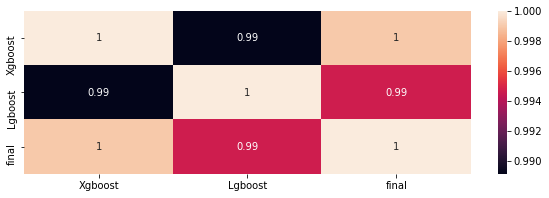

In [71]:
sns.heatmap(e_results.corr(),annot=True)

In [72]:
# Make Submission
result = pd.DataFrame({"Id": list(test_id), 'Sales': list(e_results.final)})
result.to_csv("submission.csv", index=False)

In [73]:
# final test result is 0.12175